<h1 align="center">Mushrooms</h1>
<h5 align="center">by</h5>
<h3 align="center">Monde Anna</h3>

<br />
<br />


<h3 align="center">Edible or Not</h3>
<h5 align="center">Predicted with the Aid of Decision Trees</h5>

<br />

<p>We will train a <b><i>Decision Tree</i></b> model on 23 species of gilled mushrooms in the Agaricus and Lepiota Family and further test the accuracy of said model.</p>

<br />
<br />


In [1]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


<br />

<h3 align="center">Globals</h3>

<br />
<br />


In [2]:
SEED = 42
SERIES = pd.core.series.Series


<br />

<h3 align="center">Data Exploration</h3>

<br />
<br />


<h5 align="center">Raw Data</h5>

<br />
<br />


In [3]:
path_to_data = "../data/mushrooms.csv"
mushrooms = pd.read_csv(path_to_data)
mushrooms.head()


,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g


<br />

<h5 align="center">Observation</h5>

<br />

<ul>
    <li>The feature names are non-descriptive</li>
    <br />
    <li>The naming scheme is difficult to follow, examples being:</li>
    <ul>
        <li>The target, <b><i>Is Edible</i></b> is named <b><i>p</i></b> and the <b><i>Odor</i></b> feature is named <b><i>p.1</i></b>. These two are not subsets of one another, yet carry similar naming</li>
        <li><b><i>Stalk Color</i></b>, both above and below the ring are respectively named <b><i>w</i></b> and <b><i>w.1</i></b>. This is logical. Yet further on, <b><i>Veil Color</i></b> is named <b><i>w.2</i></b></li>
        <li>For clarity as to feature names, see the index of the schema below</li>
    </ul>
    <br />
    <li>Cell values are strings as opposed to being numeric</li>
</ul>

<br />
<br />


<h5 align="center">Schema</h5>

<br />
<br />


In [4]:
path_to_schema = "../data/schema.csv"
schema = pd.read_csv(path_to_schema)
schema.set_index("Feature", inplace=True)
schema.head(4)


,Cell Value A,Cell Value B,Cell Value C,Cell Value D,Cell Value E,Cell Value F,Cell Value G,Cell Value H,Cell Value I,Cell Value J,Cell Value K,Cell Value L
Feature,,,,,,,,,,,,
is_edible,p = poisonous,e = edible,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cap_shape,b = bell,c = conical,x = convex,f = flat,k = knobbed,s = sunken,NaN,NaN,NaN,NaN,NaN,NaN
cap_surface,f = fibrous,g = grooves,y = scaly,s = smooth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cap_color,n = brown,b = buff,c = cinnamon,g = gray,r = green,p = pink,u = purple,e = red,w = white,y = yellow,NaN,NaN


<br />

<h5 align="center">Assumptions</h5>

<br />

<ul>
    <li>The features are ordered in the same manner as the raw data in the schema</li>
    <br />
    <li>Should the above be the case, then it would make sense that each feature in the raw data should have the same or lower number of unique values as compared to the schema</li>
    <br />
    <li>Recall that the schema has the <b><i>Feature</i></b> set as a feature, within which are the names of the features found in the raw data (whew!). As such:
        <ul>
            <li>The schema shall be transposed; this ensures that unique values can be calculated for what will be a feature after the transposition</li>
            <li>The initial <b><i>Feature</i></b> column, now an index, will then be dropped otherwise it will be regarded as yet another value in the new feature set</li>
        </ul>
    </li>
</ul>

<br />
<br />


<h5 align="center">Assertion of Assumption</h5>
<h5 align="center">Values in Raw Data within the Schema's Range</h5>

<br />
<br />


In [5]:
def parse_feature_values_from_schema(schema_df):
    parsed_schema = {}
    for feature in schema_transposed.columns:
        parsed_list = []
        unique_values = schema_transposed[feature].unique()
        actual_values_list = unique_values.tolist()
        if np.nan in actual_values_list:
            actual_values_list.remove(np.nan)
        for string in actual_values_list:
            parsed_list.append(string[0])
        parsed_schema[feature] = parsed_list
    return parsed_schema


<br />

<h5 align="center">Check for Range</h5>

<br />
<br />


In [6]:
mushrooms.columns = schema.index


In [7]:
schema_transposed = schema.T
schema_transposed.columns = schema.index


In [8]:
for feature in mushrooms.columns:
    observed_value_count = mushrooms[feature].nunique()
    expected_value_count = schema_transposed[feature].nunique()
    assert observed_value_count <= expected_value_count


<br />

<h5 align="center">Check for Undefined Values</h5>

<br />
<br />


In [9]:
schema_parsed = parse_feature_values_from_schema(schema_transposed)


In [10]:
for feature, schema_values in schema_parsed.items():
    for cell_value in mushrooms[feature]:
        assert cell_value in schema_values


<br />

<h5 align="center">Descriptive Statistics</h5>

<br />
<br />


In [11]:
mushrooms.describe().iloc[:, :12]


Feature,is_edible,cap_shape,cap_surface,cap_color,has_bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,stalk_root
count,8123,8123,8123,8123,8123,8123,8123,8123,8123,8123,8123,8123
unique,2,6,4,10,2,9,2,2,2,12,2,5
top,e,x,y,n,f,n,f,c,b,b,t,b
freq,4208,3655,3244,2283,4748,3528,7913,6811,5612,1728,4608,3776


In [12]:
schema_transposed.describe().iloc[:, :12]


Feature,is_edible,cap_shape,cap_surface,cap_color,has_bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,stalk_root
count,2,6,4,10,2,9,4,3,2,12,2,7
unique,2,6,4,10,2,9,4,3,2,12,2,7
top,p = poisonous,b = bell,f = fibrous,n = brown,t = bruised,a = almond,a = attached,c = close,b = broad,k = black,e = enlarging,b = bulbous
freq,1,1,1,1,1,1,1,1,1,1,1,1


<br />

<h5 align="center">Observations</h5>

<br />

<ul>
    <li>We have shown that indeed, the values in the observed data reflect what the schema states</li>
    <br />
    <li>There are no unmentioned cell values</li>
    <br />
    <li>The raw data's unique value count is less than or equal to that of the schema</li>
    <br />
    <li>All this is reflected by the descriptive statistics</li>
</ul>

<br />
<br />


<h5 align="center">Train-Test Split</h5>

<br />
<br />

In [13]:
split = train_test_split(mushrooms, test_size=0.2, random_state=SEED)
mushrooms_train, mushrooms_test = split


<br />

<h5 align="center">Duplicates and Null Values</h5>

<br />
<br />


In [14]:
num_of_samples_in_train_data = mushrooms_train.shape[0]

duplicates = mushrooms_train.duplicated().sum()
null_values = mushrooms_train.isin(["?"]).sum().sum()

duplicates_proportion = duplicates / num_of_samples_in_train_data
null_values_proportion = null_values / num_of_samples_in_train_data

invalid_data = {
    "duplicates": duplicates,
    "null values": null_values,
    "total values": num_of_samples_in_train_data,
    "proportion of duplicate values": duplicates_proportion,
    "proportion of null values": null_values_proportion,
}

pd.DataFrame(invalid_data, index=["values"])


,duplicates,null values,total values,proportion of duplicate values,proportion of null values
values,0,1989,6498,0.0,0.306094


<br />

<h5 align="center">Observation</h5>

<br />

<ul>
    <li>About 31% percent of the samples have a null/missing value</li>
    <br />
    <li>According to the schema, this only applies to the <b><i>Stalk Root</i></b> feature</li>
    <br />
    <li>Considering the above, it would be premature to drop these samples prior to exploring what correlation the <b><i>Stalk Root</i></b> feature has with the <b><i>Is Edible</i></b> feature</li>
    <br />
    <li>Instead, we will have a look as to what effect keeping samples with null values has</li>
</ul>

<br />
<br />


<h5 align="center">One-Hot Encoding</h5>

<br />

<p>All the features in the data are nominal. Considering this, it makes sense to <i>One-Hot Encode</i> each feature so as to better isolate the nominal values therein. Secondly, this option is relatively lateral which should hopefully limit any damage done by using shallow trees.</p>

<br />
<br />


In [15]:
def run_ordinal_encoder(data_frames):
    new_data_frames = []
    for frame in data_frames:
        encoder = OrdinalEncoder()
        encoder.fit(frame)

        encoded_array = encoder.transform(frame)

        encoded_frame = pd.DataFrame(
            data=encoded_array,
            columns=frame.columns
        )
        
        new_data_frames.append(encoded_frame)

    return new_data_frames


In [16]:
mushrooms_train_dropped_na = mushrooms_train.replace("?", np.nan).dropna()

encodings = run_ordinal_encoder([
    mushrooms,
    mushrooms_train,
    mushrooms_train_dropped_na,
    mushrooms_test,
])

mushrooms_encoded, mushrooms_train_encoded, mushrooms_train_dropped_na_encoded, mushrooms_test_encoded = encodings

mushrooms_train_encoded.iloc[:4, :12]


Feature,is_edible,cap_shape,cap_surface,cap_color,has_bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,stalk_root
0,1.0,5.0,3.0,9.0,0.0,2.0,1.0,0.0,0.0,7.0,0.0,1.0
1,1.0,5.0,3.0,2.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0
2,1.0,2.0,3.0,2.0,0.0,8.0,1.0,0.0,1.0,0.0,1.0,0.0
3,1.0,5.0,2.0,2.0,0.0,7.0,1.0,0.0,1.0,0.0,1.0,0.0


<br />

<h3 align="center">Data Visualisation</h3>

<br />
<br />


<br />

<h5 align="center">Correlation Heatmap</h5>

<br />

<ul>
    <li>The heatmap show <i>r<sup>2</sup></i> correlational values between features</li>
    <br />
    <li>The effect of each pair is based on <b><i>Cohen (1988)</i></b>:
        <table>
        <tr style="heigh:200%">
            <th>Range</th>
            <th>Effect Size</th>
        </tr>
        <tr>
            <td><i>r<sup>2</sup></i> &lt; 0.10</td>
            <td>trivial</td>
        </tr>
        <tr>
            <td>0.10 &le; <i>r<sup>2</sup></i> &lt; 0.25</td>
            <td>small to medium</td>
        </tr>
        <tr>
            <td>0.25 &le; <i>r<sup>2</sup></i> &lt; 0.50</td>
            <td>medium to large</td>
        <tr>
            <td><i>r<sup>2</sup></i> &ge; 0.50</td>
            <td>large</td>
        </tr>
        </table>
    </li>
</ul>

<br />
<br />


In [17]:
def generate_corr_heatmap(data, title=None, vmax=1.0):
    if type(data) == SERIES:
        heatmap = generate_series_corr_heatmap(data, vmax)
    else:
        heatmap = generate_dataframe_corr_heatmap(data, vmax)

    append_labelling(data, heatmap, title)


In [18]:
def append_labelling(data, heatmap, title):
    description = "Feature Set Correlation Heatmap"

    if title is None:
        title = description
    else:
        title = f"{description}\n{title}"

    color_bar_labelling(heatmap)
    
    heatmap.set_title(title)
    heatmap.set_ylabel("$R^2$ Correlation")
    heatmap.set_xlabel("$R^2$ Correlation")

    tick_labelling(data, heatmap)

    plt.show()

In [19]:
def color_bar_labelling(heatmap):
    colorbar = heatmap.collections[0].colorbar
    colorbar.set_ticklabels([
        "Trivial",
        "Small",
        "Medium",
        "Large",
        "Perfect"]
    )


In [20]:
def tick_labelling(data, heatmap):
    xtick_labels = [
        word.replace("_", " ").title()
        for word in data.columns
    ]

    ytick_labels = [
        word.replace("_", " ").title()
        for word in data.index
    ]

    heatmap.set_xticklabels(xtick_labels)
    heatmap.set_yticklabels(ytick_labels)


In [21]:
def generate_dataframe_corr_heatmap(data, vmax):
    mask = np.triu(data)
    np.fill_diagonal(a=mask, val=False)

    return sns.heatmap(
        data=data,
        mask=mask,
        vmax=vmax,
        cbar_kws={
            "label": "$r^2$ Correlational Strength",
            "ticks": [0.00, 0.10, 0.25, 0.50, 1.00]
        },
    )


In [22]:
def generate_series_corr_heatmap(data, vmax):
    return sns.heatmap(
        data=data,
        vmax=vmax,
        annot=True,
        cbar_kws={
            "label": "$r^2$ Correlational Strength",
            "ticks": [0.00, 0.10, 0.25, 0.50]
        },
    )


<br />

<h5 align="center">Calculate r<sup>2</sup></h5>

<br />
<br />


In [23]:
corr = mushrooms_train_encoded.corr()
squared_corr = corr ** 2


In [24]:
corr_dropped_na = mushrooms_train_dropped_na_encoded.corr()
squared_corr_dropped_na = corr_dropped_na ** 2


<br />

<h5 align="center">Null Values Present</h5>

<br />
<br />


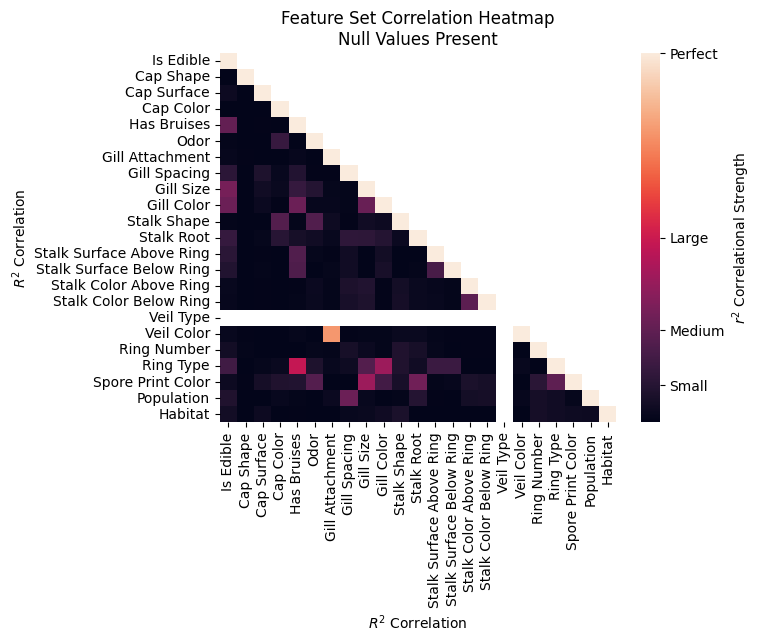

In [25]:
generate_corr_heatmap(
    data=squared_corr,
    title="Null Values Present"
)


<br />

<h5 align="center">Null Values Removed</h5>

<br />
<br />


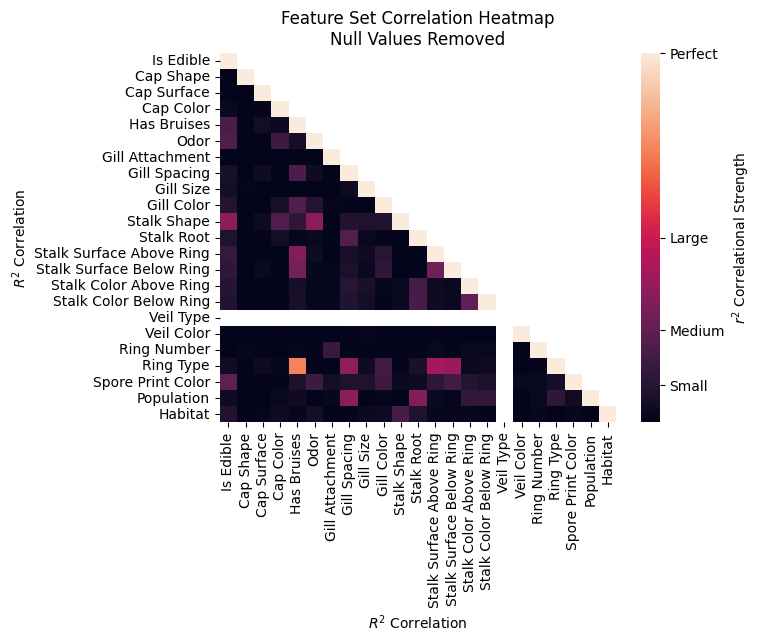

In [26]:
generate_corr_heatmap(
    data=squared_corr_dropped_na,
    title="Null Values Removed"
)


<br />

<h5 align="center">Initial Observations</h5>

<br />

<table align="center">
    <tr>
        <th>Correlational Strength</th>
        <th>Samples with Null Present</th>
        <th>No Samples with Null Values</th>
    </tr>
    <br />
    <tr>
        <th>Strong</th>
        <td><b><i>Veil Color</i></b> and <b><i>Gill Attachment</i></b></td>
        <td><b><i>Ring Type</i></b> and <b><i>Has Bruises</i></b></td>
    </tr>
    <tr>
        <th>Moderate</th>
        <td><b><i>Ring Type</i></b> and <b><i>Has Bruises</i></b></td>
        <td><b><i>Ring Type</i></b> and <b><i>Stalk Surfaces</i></b></td>
    </tr>
    <tr>
        <th>Moderate</th>
        <td><b><i>Spore Print Count</i></b> and <b><i>Gill Size</i></b></td>
        <td><b><i>Ring Type</i></b> and <b><i>Gill Spacing</i></b></td>
    </tr>
    <tr>
        <th>Moderate</th>
        <td><b><i>Ring Type</i></b> and <b><i>Gill Color</i></b></td>
        <td><b><i>Has Bruises</i></b> and <b><i>Stalk Surfaces</i></b></td>
    </tr>
    <tr>
        <th>Moderate</th>
        <td>-</td>
        <td><b><i>Is Edible</i></b> and <b><i>Stalk Shape</i></b></td>
    </tr>
    <tr>
        <th>Moderate</th>
        <td>-</td>
        <td><b><i>Odor</i></b> and <b><i>Stalk Shape</i></b></td>
    </tr>
    <tr>
        <th>Moderate</th>
        <td>-</td>
        <td><b><i>Population</i></b> and <b><i>Stalk Root</i></b></td>
    </tr>
    <tr>
        <th>Moderate</th>
        <td>-</td>
        <td><b><i>Population</i></b> and <b><i>Gill Spacing</i></b></td>
    </tr>
</table>

<br />

<ul>
    <li>Excluding the above, it is difficult to eyeball the sprinkings of correlational values slightly above 0.25</li>
</ul>

<br />
<br />


<h5 align="center">Addressing Veil Type</h5>

<br />
<br />


In [27]:
mushrooms_train_encoded["veil_type"].unique()


array([0.])

### $$
        r = \frac
            {
                \Sigma (x_i - \hat{x}) (y_i - \hat{y})
            }
                {\sqrt {(x_i - \hat{x})^2 (y_i - \hat{y})^2}
            }
$$


<br />

<ul>
    <li>As illustrated by the <b><i>Pearson r Correlation</i></b> formula above, <i>x<sub>i</sub> == x&#770;</i> results in zero division</li>
    <br />
    <li>Noting the above, we will run the heatmap again, this time:
        <ul>
            <li>Remove the <b><i>Veil Type</i></b> feature</li>
            <li>Reduce the maximum value of the correlational range from 1.0 to 0.25. Though extreme, this should easily highlight which features have a medium and greater <i>r<sup>2</sup></i> value</li>
        </ul>
    </li>
</ul>

<br />
<br />


<br />

<h5 align="center">Null Values Present</h5>

<br />
<br />


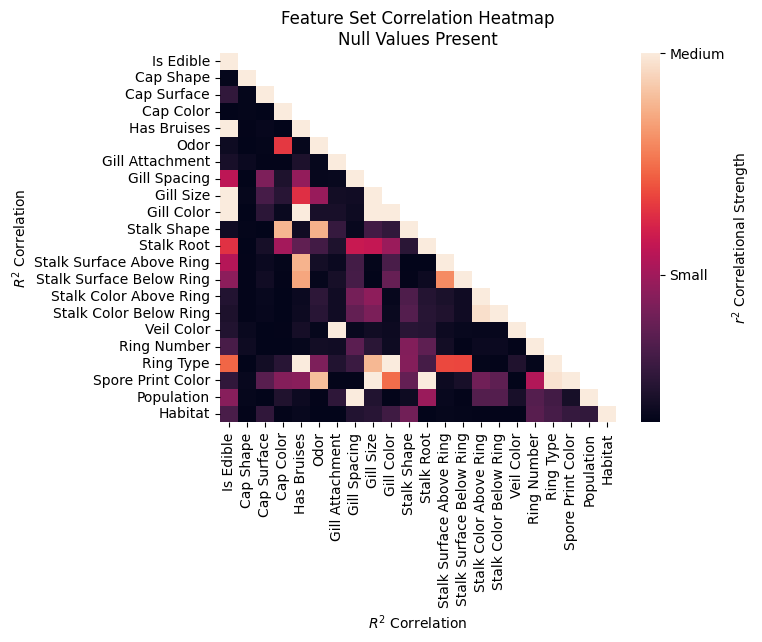

In [28]:
veil = ["veil_type"]

squared_corr_trimmed = squared_corr.drop(
    columns=veil,
    index=veil,
)

generate_corr_heatmap(
    data=squared_corr_trimmed,
    vmax=0.25,
    title="Null Values Present",
)


<br />

<h5 align="center">Null Values Removed</h5>

<br />
<br />


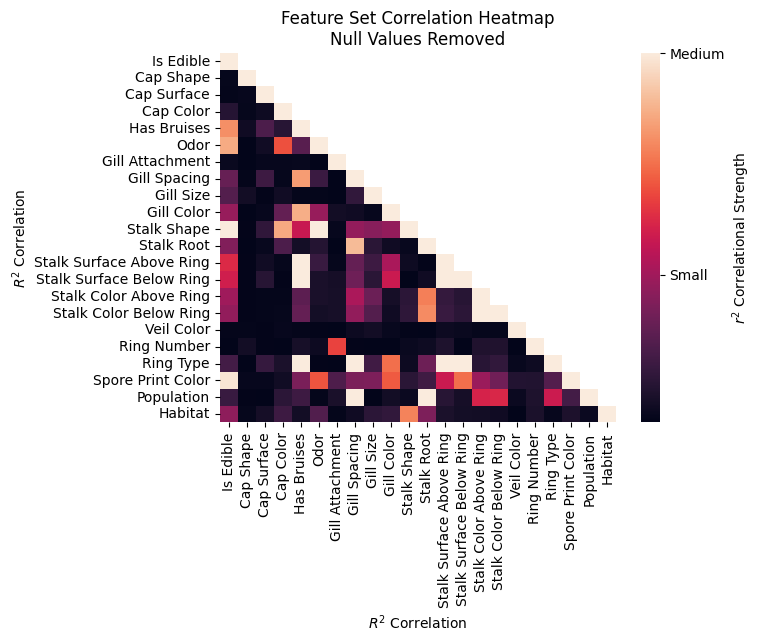

In [29]:
squared_corr_dropped_na_trimmed = squared_corr_dropped_na.drop(
    columns=veil,
    index=veil,
)

generate_corr_heatmap(
    data=squared_corr_dropped_na_trimmed,
    vmax=0.25,
    title="Null Values Removed",
)


<br />

<h5 align="center">Secondary Observations</h5>

<br />

<ul>
    <li>Minimal patterns can be drawn from the data as is</li>
    <br />
    <li>Most correlations are below 0.10, biased below 0.05</li>
    <br />
    <li>Samples with Null Values present: moderate to high correlation to <b><i>Is Edible</i></b>
        <ul>
            <li><b><i>Has Bruises</i></b></li>
            <li><b><i>Gill Color</i></b></li>
            <li><b><i>Gill Size</i></b></li>
            <li>Sadly, <b><i>Has Bruises</i></b> and <b><i>Gill Color</i></b> are covariates as they too show a medium to strong correlation</li>
        </ul>
    </li>
    <br />
    <li>Samples with Null Values removed: moderate to high correlation to <b><i>Is Edible</i></b>
        <ul>
            <li><b><i>Spore Print Count</i></b></li>
            <li><b><i>Stalk Shape</i></b></li>
        </ul>
    </li>
</ul>

<br />
<br />


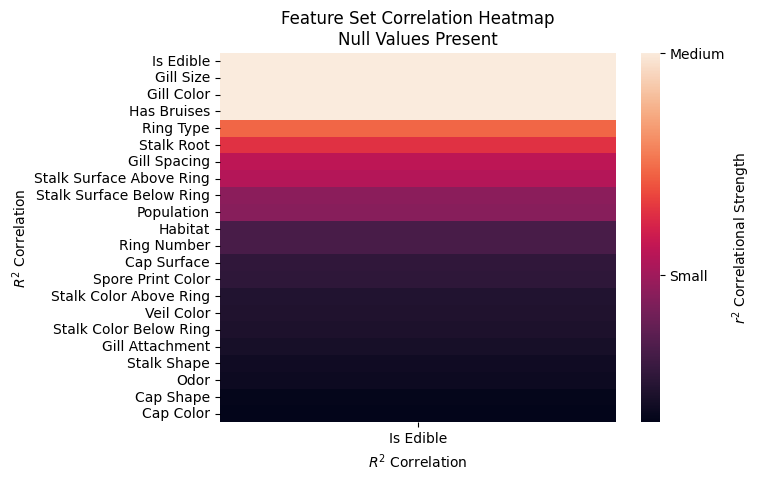

In [30]:
is_edible = squared_corr_trimmed[["is_edible"]].sort_values(
    by="is_edible",
    ascending=False
)

generate_corr_heatmap(
    data=is_edible,
    vmax=0.25,
    title="Null Values Present"
)


<br />

<h5 align="center">Final Observations</h5>

<br />

<ul>
    <li>Focusing purely on the target further cements the eye-balled observation regarding <b><i>Is Edible's</i></b> medium to strong correlators:
        <ul>
            <li><b><i>Has Bruises</i></b></li>
            <li><b><i>Gill Color</i></b></li>
            <li><b><i>Gill Size</i></b></li>
        </ul>
    </li>
    <br />
    <li>Recall:
        <ul>
            <li><b><i>Has Bruises</i></b> and <b><i>Gill Color</i></b> are moderately covariate</li>
            <li><b><i>Stalk Root</i></b> Has missing values, though as is, shows week correlation to <b><i>Is Edible</i></b></li>
        </ul>
    </li>
</ul>

<br />
<br />


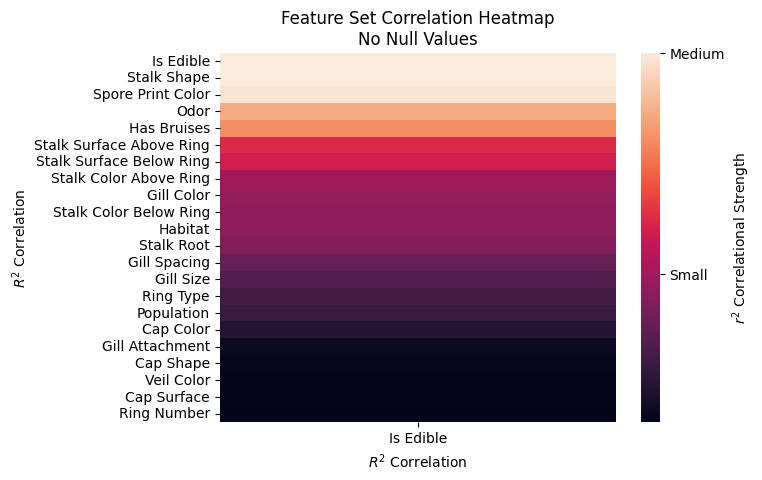

In [31]:
is_edible_na_trimmed = squared_corr_dropped_na_trimmed[["is_edible"]].sort_values(
    by="is_edible",
    ascending=False
)

generate_corr_heatmap(
    data=is_edible_na_trimmed,
    vmax=0.25,\
    title="No Null Values"
)


<br />

<h3 align="center">Feature Selection</h3>

<br />

<p>We will alternate between <b><i>Has Bruises</i></b> and <b><i>Gill Color</i></b> in order to find the better feature set.</p>

<br />
<br />


In [32]:
def get_model_accuracy(
    data, features, classifier, max_depth=None, min_weight_fraction_leaf=0.0
):
    X = data[features]
    y = data["is_edible"]

    algorithm = classifier(
        max_depth=max_depth,
        min_weight_fraction_leaf=min_weight_fraction_leaf,
        random_state=SEED,
    )
    
    algorithm.fit(X, y)
    predictions = algorithm.predict(X)

    return accuracy_score(y, predictions)


<br />

<h5 align="center">Samples with Null Values Present</h5>
<h5 align="center">Bruising and Gill Size</h5>

<br />
<br />


In [33]:
has_bruises_feature_set = ["has_bruises", "gill_size"]

has_bruises_accuracy = get_model_accuracy(
    data=mushrooms_train_encoded,
    features=has_bruises_feature_set,
    classifier=DecisionTreeClassifier
)


<br />

<h5 align="center">Samples with Null Values Present</h5>
<h5 align="center">Gill Color and Gill Size</h5>

<br />
<br />


In [34]:
gill_color_feature_set = ["gill_color", "gill_size"]

gill_color_accuracy = get_model_accuracy(
    data=mushrooms_train_encoded,
    features=gill_color_feature_set,
    classifier=DecisionTreeClassifier
)


<br />

<h5 align="center">Samples with No Null Values Present</h5>
<h5 align="center">Stalk Shape and Spore Print Color</h5>

<br />
<br />


In [35]:
stalk_shape_feature_set = ["stalk_shape", "spore_print_color"]

stalk_shape_accuracy = get_model_accuracy(
    data=mushrooms_train_dropped_na_encoded,
    features=gill_color_feature_set,
    classifier=DecisionTreeClassifier
)


In [36]:
pd.DataFrame(
    data={
        "Nulls: Has Bruises": has_bruises_accuracy,
        "Nulls: Gill Color": gill_color_accuracy,
        "No Nulls: Stalk Shape": stalk_shape_accuracy,
    },
    index=["Values"]
)


,Nulls: Has Bruises,Nulls: Gill Color,No Nulls: Stalk Shape
Values,0.767775,0.830563,0.783322


<br />

<h5 align="center">Observation</h5>

<br />

<ul>
    <li>Gill Color shows a higher <i>r<sup>2</sup></i> value</li>
    <br />
    <li>Considering that <b><i>Stalk Root</i></b> is the only feature with null values and that it has no impact on the <b><i>Gill Color</i></b> feature set, we will proceed with said feature set</li>
</ul>

<br />
<br />


<h3 align="center">Finding the Model</h3>

<br />

<p>Having found what features to operate with, we will now fine-tune the hyperparameters mentioned below using a <b><i>Grid Search Cross-Validator</i></b>. As for now, we will take a brute force approach, whereby we will have:
    <ul>
        <br />
        <li>Our <b><i>Criterion</i></b> will be:
            <ul>
                <li>Gini</li>
                <li>Entropy</li>
                <li>Log Loss</li>
            </ul>
        </li>
        <br />
        <li><b><i>Max Depth</i></b> will range from 1 to 10</li>
        <br />
        <li><b><i>Minimum Weight Fraction Leaf </i></b> to range from 0.0 to 0.50, incremented by 0.05</li>
        <br />
        <li>The <b><i>Splitter</i></b> will alternate between:
            <ul>
                <li>Best</li>
                <li>Random</li>
            </ul>
        </li>
        <br />
        <li><b><i>Cross-Validation</i></b> to be set to 10</li>
    </ul>
</p>

<br />

<p>Again, the above selection is both arbitrary and experimental.</p>

<br />
<br />


In [37]:
def calculate_tuning_findings(y, y_hat):
    precision = precision_score(y, y_hat, zero_division=0)
    roc_auc = roc_auc_score(y, y_hat)
    accuracy = accuracy_score(y, y_hat)
    recall = recall_score(y, y_hat)
        
    mse = MSE(y, y_hat)
    rmse = mse ** 0.5
        
    results = {
        "precision": precision,
        "recall": recall,
        "roc-auc": roc_auc,
        "r-squared": accuracy,
        "rmse": rmse,
    }
    
    return results


<br />

<h5 align="center">Decision Tree Parameters</h5>

<br />
<br />


In [38]:
range_of_5_thousandths = [x / 100 for x in range(0, 51, 5)]

parameters = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": range(1,11),
    "min_weight_fraction_leaf": range_of_5_thousandths,
    "splitter": ["best", "random"],
    "random_state": [SEED],
}


<br />

<h5 align="center">Grid Search Cross Validator</h5>

<br />
<br />


In [39]:
grid_search_cv = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=parameters,
    scoring="accuracy",
    cv=10,
    n_jobs=-1,
)


<br />

<h5 align="center">Training</h5>

<br />
<br />


In [40]:
X_train = mushrooms_train_encoded[gill_color_feature_set]
y_train = mushrooms_train_encoded["is_edible"]


In [41]:
_ = grid_search_cv.fit(X_train, y_train)


<br />

<h3 align="center">Evaluations</h3>

<br />
<br />


<h5 align="center">Trial Against Test Data</h5>

<br />
<br />


In [42]:
X_test = mushrooms_test_encoded[gill_color_feature_set]
y_test = mushrooms_test_encoded["is_edible"]


In [43]:
predictions = grid_search_cv.predict(X_test)
trial_against_test = calculate_tuning_findings(
    y_test, predictions
)


In [44]:
pd.DataFrame(
    data=trial_against_test,
    index=["trial against test"]
)


,precision,recall,roc-auc,r-squared,rmse
trial against test,0.811014,0.839378,0.831178,0.830769,0.411377


<br />

<h5 align="center">Observations</h5>

<br />

<ul>
    <li>The best metrics are:
        <ul>
            <li><b><i>Precision</i></b>: 0.826825</li>
            <li><b><i>Recall</i></b>: 0.821826</li>
            <li><b><i>ROC/AUC</i></b>: 0.830287</li>
            <li><b><i>r<sup>2</sup></i></b>: 0.830563</li>
            <li><b><i>RMSE</i></b>: 0.411627</li>
        </ul>
    </li>
</ul>

<br />
<br />


<h5 align="center">Optimal Decision Tree Parameters</h5>

<br />
<br />


In [45]:
best_parameters = grid_search_cv.best_params_

pd.DataFrame(
    data=best_parameters,
    index=["optimum setting"]
)


,criterion,max_depth,min_weight_fraction_leaf,random_state,splitter
optimum setting,gini,5,0.0,42,best


<br />

<h5 align="center">Observations</h5>

<br />

<ul>
    <li>The best results seem to come from:
        <ul>
            <li>Setting the <b><i>Criterion</i></b> to <b><i>Gini</i></b></li>
            <li>A <b><i>Max Depth</i></b> of <b><i>5</i></b></li>
            <li><b><i>Minimum Weight Fraction Leaf </i></b> being set to <b><i>0.00</i></b></li>
            <li><b><i>Splitter</i></b> being set to <b><i>Best</i></b></li>
        </ul>
    </li>
    <br />
    <li>You will recall that the <b><i>Splitter</i></b> is a seeded value</li>
</ul>

<br />
<br />


<h5 align="center">Prevalence</h5>

<br />

<p>Now to look for the total number of edible mushrooms in the whole data set when divided by the number of observed mushrooms.</p>

<br />
<br />


In [46]:
model = grid_search_cv.best_estimator_

mushrooms_edibility_prediction = model.predict(
    mushrooms_encoded[gill_color_feature_set]
)

prevalence_from_model = mushrooms_edibility_prediction.sum() / len(mushrooms_encoded)


In [47]:
mask = mushrooms["is_edible"] == "e"
prevalence_actual = mushrooms[mask].shape[0] / mushrooms.shape[0]


In [48]:
pd.DataFrame(
    data={
        "model": prevalence_from_model,
        "actual": prevalence_actual,
        "proportion": prevalence_from_model / prevalence_actual,
    },
    index=["values"]
)


,model,actual,proportion
values,0.48295,0.518035,0.932272


<br />

<h5 align="center">Observations</h5>

<br />

<ul>
    <li>Not the best, not the worst</li>
    <br />
    <li>The model shows an accuracy of 0.93</li>
</ul>

<br />
<br />


<h3 align="center">Conclusion</h3>

<br />

<p>We've created a fairly accurate model using minimal resources:
    <ul>
        <li>Only two features have been used: <b><i>Gill Color</i></b> and <b><i>Gill Size</i></b></li>
        <li><b><i>Max Depth</i></b> is 5</li>
        <li>Have a Precision, Recall, ROC and an <i>r<sup>2</sup></i> that are <b><i>above 0.80</i></b></li>
        <li>Managed to predict the <b><i>Prevalence of Edible Mushrooms</i></b> to a proportion <b><i> of 0.93</i></b></li>
    </ul>
</p>

<br />

<p>Sadly, we've incurred some expenses along the way in that:
    <ul>
        <li><b><i>Minimum Weight Fraction Leaf </i></b> is 0.00</li>
        <li><b><i>RMSE</i></b> is rather high at about 0.41</li>
    </ul>
</p>

<br />
<br />
